In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cvxpy as cp

In [4]:
class InjectSimulator:
    # Total segments 
    TOTAL_G = 9258*(10**3)
    # Total storage domains
    TOTAL_M = 18
    # Total sessions 
    TOTAL_N = 9258
    # Total injection, dynamic
    TOTAL_C = 345*100

    def __init__(self):
        self.Nlist = np.array([3775, 3410, 563 ,551, 457, 300,
            54, 51, 42, 19, 14, 13,
            3, 2, 1, 1, 1, 1]) 
        self.Glist = self.Nlist * (10**2)

    def nothing(self):
        # internal gain
        Dlist = (self.Glist - self.Nlist * 2) * np.log(1 + 1/self.Nlist)
        print('Di: {0}\nmin Di: {1}'.format(Dlist, min(Dlist)))
        with open('nothing.txt', 'w') as fp:
            for value in Dlist:
                fp.write('{0}\n'.format(value))

    def average(self):
        # internal gain
        Dlist = (self.Glist - self.Nlist * 2) * np.log(1 + 1/self.Nlist)
        # print(Dlist)
        Clist = np.array([self.TOTAL_C/self.TOTAL_M] * self.TOTAL_M)
        # print(Clist)

        Ji_values = Clist * np.log(1 + self.Nlist) + Dlist
        print('Ji: {0}\nmin Ji: {1}'.format(Ji_values, min(Ji_values)))

        J_values = np.sum(Ji_values)
        print('Jv: {0}\navg Jv: {1}'.format(J_values, J_values/self.TOTAL_M))

        with open('average.txt', 'w') as fp:
            for value in Ji_values:
                fp.write('{0}\n'.format(value))

    def optim(self, alpha):
        # internal gain
        Dlist = (self.Glist - self.Nlist * 2) * np.log(1 + 1/self.Nlist)
        
        # to be solved
        Clist = cp.Variable(self.TOTAL_M, integer=True)

        # Minimum Ji: Objective function 1
        Ji = cp.min(cp.multiply(np.log(1 + self.Nlist), Clist) + Dlist)
        
        # Maximize Minimum Ji
        objective = cp.Maximize(Ji)

        constraints = [
            cp.sum(Clist) <= self.TOTAL_C,
            Clist >= 1]

        problem = cp.Problem(objective, constraints)

        optimal_value = problem.solve()

        epsilon = alpha * optimal_value

        # Maximum Jv: Objective function 2
        Clist = cp.Variable(self.TOTAL_M, integer=True)

        Ji = cp.min(cp.multiply(np.log(1 + self.Nlist), Clist) + Dlist)
        J = cp.sum(cp.multiply(np.log(1 + self.Nlist), Clist) + Dlist)

        objective = cp.Maximize(J)

        constraints = [
            Ji >= epsilon,
            cp.sum(Clist) <= self.TOTAL_C,
            Clist >= 1]

        problem = cp.Problem(objective, constraints)

        optimal_value = problem.solve()
        
        # checkout if the optimal status
        # print(problem.status)
        # print('optimal value: {0}'.format(optimal_value))
        print('optimal variables : {0}'.format(Clist.value))

        Ji_values = Clist.value * np.log(1 + self.Nlist) + Dlist
        print('Ji: {0}\nmin Ji: {1}'.format(Ji_values, min(Ji_values)))

        Jv_values = np.sum(Ji_values)
        print('Jv: {0}\navg Jv: {1}'.format(Jv_values, Jv_values/self.TOTAL_M))

        with open('optimal_{}.txt'.format(alpha), 'w') as fp:
            for value in Ji_values:
                fp.write('{0}\n'.format(value))

In [5]:
def start_simulation():
    simu = InjectSimulator()
    for alpha in [0.8, 0.85, 0.9, 0.95]:
        simu.optim(alpha)
    # simu.optim()
    simu.average()
    simu.nothing()

start_simulation()

optimal variables : [7381.  330.  424.  425.  438.  471.  670.  680.  714.  897.  992. 1018.
 1945. 2459. 3914. 3914. 3914. 3914.]
Ji: [60891.00693391  2782.45669151  2783.97607181  2781.1690979
  2781.46163779  2785.88596342  2782.01687594  2783.89732175
  2782.34840995  2782.67996353  2781.04401917  2780.97391807
  2780.92106168  2780.95877902  2780.90648841  2780.90648841
  2780.90648841  2780.90648841]
min Ji: 2780.9064884065006
Jv: 108184.42269906797
avg Jv: 6010.245705503777
optimal variables : [5641.  352.  451.  453.  467.  501.  713.  724.  760.  955. 1056. 1084.
 2070. 2617. 4164. 4164. 4164. 4164.]
Ji: [46559.63521646  2961.42142872  2955.0225366   2957.9484432
  2959.14084413  2957.09927136  2954.3322029   2957.75204537
  2955.36361527  2956.43243539  2954.35923204  2955.15170183
  2954.20785682  2954.53952063  2954.19328355  2954.19328355
  2954.19328355  2954.19328355]
min Ji: 2954.193283546487
Jv: 96809.17948491263
avg Jv: 5378.287749161813
optimal variables : [3896.  37

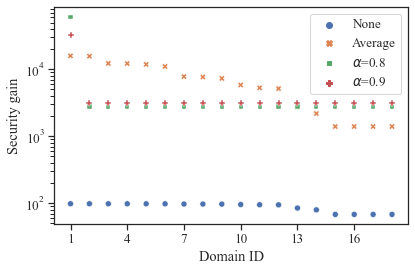

In [6]:
sns.set_theme(style='ticks', font='Times New Roman', font_scale=1.2)
def draw_domain_gain():
    paths = ['nothing.txt', 'average.txt', 'optimal_0.8.txt', 'optimal_0.9.txt']
    labels = ['None', 'Average', r'$\alpha$=0.8', r'$\alpha$=0.9']
    data = np.array([np.loadtxt(path) for path in paths])
    data = pd.DataFrame(data=data.T, index=range(1, 19), columns=labels)
    # plt.figure(figsize=(6, 4))
    ax = sns.scatterplot(data=data)
    ax.set_xlabel('Domain ID')
    ax.set_ylabel('Security gain')
    plt.xticks(range(1, 19, 3))
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig('domain_gain.png', format='png', bbox_inches='tight', dpi=300)
draw_domain_gain()

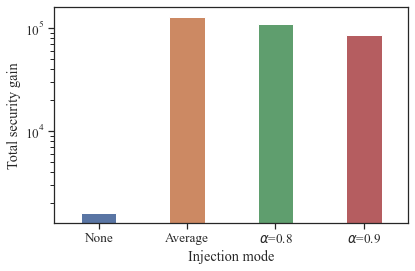

In [7]:
def draw_total_gain():
    paths = ['nothing.txt', 'average.txt', 'optimal_0.8.txt', 'optimal_0.9.txt']
    labels = ['None', 'Average', r'$\alpha$=0.8', r'$\alpha$=0.9']
    data = np.array([np.sum(np.loadtxt(path)) for path in paths])
    data = pd.DataFrame(data=data.reshape(1, len(data)), columns=labels)
    ax = sns.barplot(data=data)
    ax.set_ylabel('Total security gain')
    ax.set_xlabel('Injection mode')
    for bar in ax.patches:
        x = bar.get_x()
        width = bar.get_width()
        bar.set_x(x+width/4)
        bar.set_width(width/2)
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig('total_gain.png', format='png', bbox_inches='tight', dpi=300)
draw_total_gain()

In [48]:
def draw_pr(M):
    N = 10000
    Pr_1 = -N*np.log(N)
    Pr_2 = np.log(1-1/M)*(N**2/2)
    print(Pr_1-Pr_2)
    # sns.lineplot(N, Pr_1-Pr_2)

    
draw_pr(1460)

-57845.09473993676
